[*********************100%***********************]  1 of 1 completed


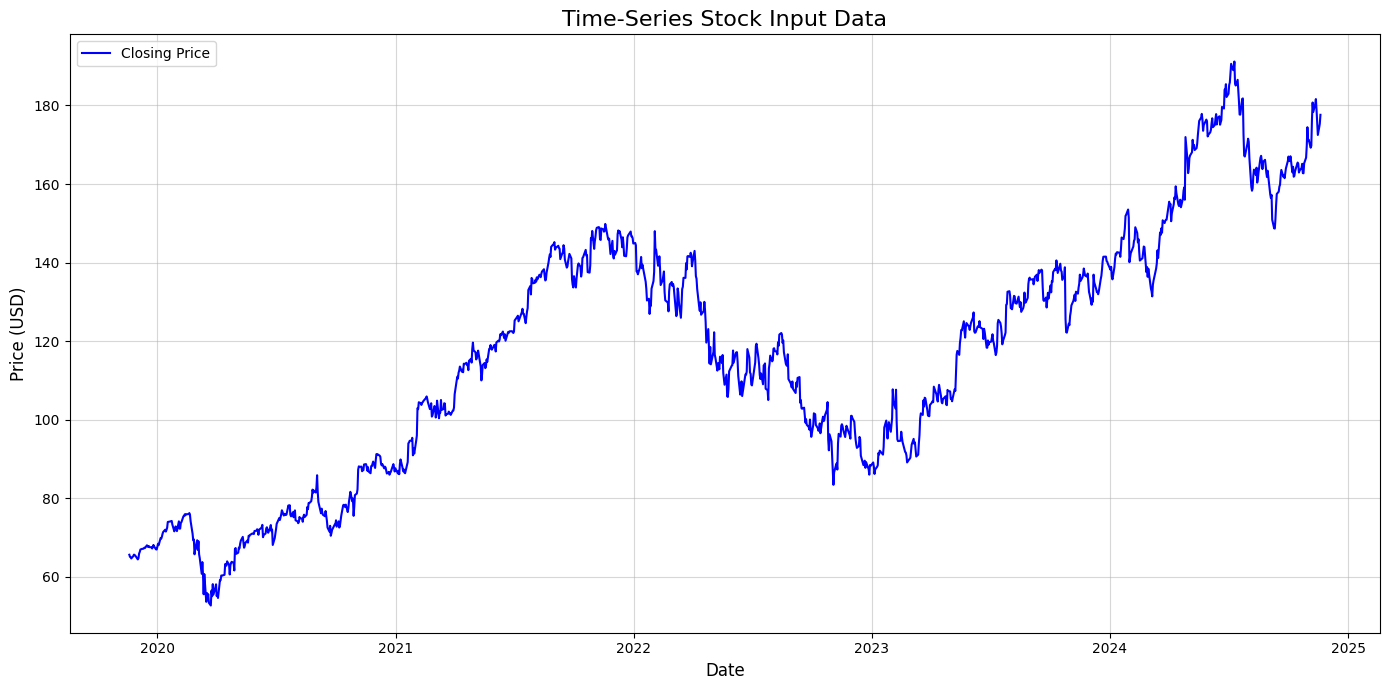

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt

# Fetch data for the past 5 years
stock_ticker = 'TSLA'  # Replace with your desired stock ticker (e.g., MSFT, TSLA)
data = yf.download(stock_ticker, period='5y')

# Plotting the closing price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Closing Price', color='blue')

# Enhancing the plot
plt.title(f'Time-Series Stock Input Data', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.5)
plt.tight_layout()

# Show the plot
plt.show()


In [ ]:
print(data['Close'])

Ticker                          GOOGL
Date                                 
2019-11-19 00:00:00+00:00   65.629501
2019-11-20 00:00:00+00:00   65.093002
2019-11-21 00:00:00+00:00   65.007004
2019-11-22 00:00:00+00:00   64.683502
2019-11-25 00:00:00+00:00   65.281998
...                               ...
2024-11-13 00:00:00+00:00  178.880005
2024-11-14 00:00:00+00:00  175.580002
2024-11-15 00:00:00+00:00  172.490005
2024-11-18 00:00:00+00:00  175.300003
2024-11-19 00:00:00+00:00  177.619995

[1259 rows x 1 columns]


In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Download stock data from Yahoo Finance
def download_stock_data(ticker, period='5y'):
    stock_data = yf.download(ticker, period=period)
    return stock_data


import requests


# Step 2: Preprocess the data
def preprocess_data(data, feature_col='Close', seq_length=60):
    # Use 'Close' prices to predict trends
    data = data[[feature_col]]

    # Normalize the data using MinMaxScaler
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Create sequences of data points for LSTM input
    X, y = [], []
    for i in range(seq_length, len(scaled_data)):
        X.append(scaled_data[i-seq_length:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)

    # Reshape the data to be compatible with LSTM (samples, timesteps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    return X, y, scaler

# Step 3: Build the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Predicting a single output value (next price)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Step 4: Train the LSTM model
def train_lstm_model(model, X_train, y_train, epochs=50, batch_size=64):
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

# Step 5: Make predictions and evaluate
def predict_and_evaluate(model, X_test, y_test, stock_scaler):
    predictions = model.predict(X_test)

    # Inverse transform only the stock price column
    predictions_stock_price = stock_scaler.inverse_transform(predictions)
    y_test_stock_price = stock_scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate the Root Mean Squared Error (RMSE) on the stock prices
    rmse = np.sqrt(np.mean((predictions_stock_price - y_test_stock_price) ** 2))
    return predictions_stock_price, rmse

# Step 6: Trading simulation logic
def simulate_trading(predictions, actual_prices, dates, initial_balance=10000, shares=0):
    balance = initial_balance
    total_shares = shares
    trade_log = []

    for i in range(1, len(predictions)):
        predicted_price = predictions[i]
        actual_price = actual_prices[i]
        date = dates[i]  # Make sure 'date' is a datetime object

        # Ensure you're not comparing dates with prices
        if predicted_price > actual_prices[i-1] and balance > actual_price:
            shares_to_buy = balance // actual_price
            balance -= shares_to_buy * actual_price
            total_shares += shares_to_buy
            trade_log.append(f"Bought {shares_to_buy} shares at {actual_prices[i][0]:.2f} on {dates[i]}")

        elif predicted_price < actual_prices[i-1] and total_shares > 0:
            balance += total_shares * actual_price
            trade_log.append(f"Sold {total_shares} shares at {actual_price[0]:.2f} on {date}, Balance: {balance:.2f}")
            total_shares = 0

    # Final balance after selling any remaining shares
    if total_shares > 0:
        balance += total_shares * actual_prices[-1]
        trade_log.append(f"Final Sale of {total_shares} shares at {actual_prices[-1][0]:.2f} on {dates[-1]}, Final Balance: {balance:.2f}")


    profit_loss = balance - initial_balance
    return trade_log, profit_loss


In [ ]:
# Step 6: Trading simulation logic
def simulate_trading(predictions, actual_prices, dates, initial_balance=10000, shares=0):
    balance = initial_balance
    total_shares = shares
    trade_log = []

    for i in range(1, len(predictions)):
        predicted_price = predictions[i]
        actual_price = actual_prices[i]
        date = dates[i]  # Make sure 'date' is a datetime object

        # Ensure you're not comparing dates with prices
        if predicted_price > actual_prices[i-1] and balance > actual_price:
            shares_to_buy = balance // actual_price
            balance -= shares_to_buy * actual_price
            total_shares += shares_to_buy
            trade_log.append(f"Bought {shares_to_buy} shares at {actual_price} on {date}, Balance: {balance}, Shares: {total_shares}")

        elif predicted_price < actual_prices[i-1] and total_shares > 0:
            balance += total_shares * actual_price
            trade_log.append(f"Sold {total_shares} shares at {actual_price} on {date}, Balance: {balance}")
            total_shares = 0

    # Final balance after selling any remaining shares
    if total_shares > 0:
        balance += total_shares * actual_prices[-1]
        trade_log.append(f"Final Sale of {total_shares} shares at {actual_prices[-1]} on {dates[-1]}, Final Balance: {balance}")

    profit_loss = balance - initial_balance
    return trade_log, profit_loss

# Step 7: Run the entire pipeline with trading simulation
def run_stock_prediction_with_simulation(ticker, period='5y', seq_length=60):
    # Download and preprocess the data
    stock_data = download_stock_data(ticker, period)
    X, y, scaler = preprocess_data(stock_data, seq_length=seq_length)

    # Get the corresponding dates for the test set
    dates = stock_data.index[seq_length:]  # Dates aligned with the sequences

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Adjust the corresponding dates for the test set
    test_dates = dates[-len(X_test):]

    # Create and train the LSTM model
    model = create_lstm_model(input_shape=(X_train.shape[1], 1))
    model = train_lstm_model(model, X_train, y_train, epochs=10)

    # Make predictions and evaluate the model
    predictions, rmse = predict_and_evaluate(model, X_test, y_test, scaler)

    # Rescale the actual test prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Simulate trading based on model predictions and include dates
    trade_log, profit_loss = simulate_trading(predictions.flatten(), actual_prices.flatten(), test_dates)

    print(f"Root Mean Squared Error: {rmse}")
    print(f"Final Profit/Loss: {profit_loss}")
    for log in trade_log:
        print(log)

    return stock_data, predictions, trade_log, profit_loss

# Example usage:
if __name__ == "__main__":
    ticker_symbol = 'GOOG '  # Example stock ticker (Apple Inc.)
    stock_data, predictions, trade_log, profit_loss = run_stock_prediction_with_simulation(ticker_symbol)


[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 0.0745
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0122
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0054
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0037
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0027
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - loss: 0.0028
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step - loss: 0.0025
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0029
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0025
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0021
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step
Root Mean Squared Error: 6.4790429971530905
Final Profit/Loss: 1110.8802947998029
Bought 74.0 shares at 133.63999938964847 on 2023-12-12 00:00:00+00:00, Balance: 110.6400451660138, Shares: 74.0
Sold 74.0 shares at 138.10000610351562 on 2023-12-19 00:00:00+00:00, Balance: 10330.04049682617
Bought 75.0 shares a

In [ ]:
!pip install pytrends

In [ ]:
from pytrends.request import TrendReq


# Step 1.1: Download Google Trends data with additional error handling
def download_trends_data(keyword, start_date, end_date):
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([keyword], timeframe=f'{start_date} {end_date}')
    trends_data = pytrends.interest_over_time()


    # Check if trends data is empty
    if trends_data.empty:
        print(f"No Google Trends data found for keyword: {keyword}")
        return None

    # Fill missing values in trends data, if any
    trends_data = trends_data.fillna(0)  # You can change the filling strategy as needed

    return trends_data


from pytrends.request import TrendReq
from textblob import TextBlob
import pandas as pd
import numpy as np
import requests

# Step 1.1: Download Google Trends data with additional error handling and sentiment analysis
def download_trends_data(keyword, start_date, end_date):
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([keyword], timeframe=f'{start_date} {end_date}')
    trends_data = pytrends.interest_over_time()

    # Check if trends data is empty
    if trends_data.empty:
        print(f"No Google Trends data found for keyword: {keyword}")
        return None

    # Fill missing values in trends data, if any
    trends_data = trends_data.fillna(0)

    # Calculate sentiment based on trend score fluctuations
    trends_data['change'] = trends_data[keyword].diff()  # Daily change in interest score
    trends_data['sentiment'] = trends_data['change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

    return trends_data

# Step 2: Preprocess the stock and trends data together
def preprocess_data_with_trends(stock_data, trends_data, feature_col='Close', seq_length=60):
    if trends_data is None:
        raise ValueError("No trends data available, cannot proceed with preprocessing.")

    trends_data.index = trends_data.index.tz_localize(None)
    stock_data.index = stock_data.index.tz_localize(None)

    # Reindex trends data to match stock data dates
    trends_data = trends_data.reindex(stock_data.index, method='ffill').fillna(0)

    # Normalize stock prices and trends data separately
    stock_scaler = MinMaxScaler(feature_range=(0, 1))
    trend_scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_stock_data = stock_scaler.fit_transform(stock_data[[feature_col]])
    scaled_trends_data = trend_scaler.fit_transform(trends_data[['sentiment']])

    # Combine the scaled stock prices and trends data
    combined_data = np.hstack((scaled_stock_data, scaled_trends_data))

    # Create sequences for LSTM input
    X, y = [], []
    for i in range(seq_length, len(combined_data)):
        X.append(combined_data[i-seq_length:i])
        y.append(scaled_stock_data[i, 0])  # Stock price (first column)

    X, y = np.array(X), np.array(y)

    return X, y, stock_scaler

# Example function to simulate trading with more realistic features
def simulate_trading_with_strategy(predictions, actual_prices, dates, initial_capital=10000, fee_rate=0.001, buy_threshold=0.01, sell_threshold=-0.01):
    capital = initial_capital
    holdings = 0  # Number of shares held
    trade_log = []
    actual_prices = actual_prices.flatten()

    for i in range(1, len(predictions)):
        predicted_change = predictions[i] - predictions[i - 1]
        actual_change = actual_prices[i] - actual_prices[i - 1]

        # Buy condition: only if the predicted increase is above the buy threshold and we have capital
        if predicted_change > buy_threshold and capital > actual_prices[i]:
            # Buy as many shares as possible within the available capital
            shares_to_buy = capital // actual_prices[i]
            capital -= shares_to_buy * actual_prices[i] * (1 + fee_rate)  # Deduct cost with fee
            holdings += shares_to_buy
            trade_log.append(f"Bought {shares_to_buy} shares at {actual_prices[i]:.2f} on {dates[i]}")

        # Sell condition: only if the predicted decrease is below the sell threshold and we have holdings
        elif predicted_change < sell_threshold and holdings > 0:
            capital += holdings * actual_prices[i] * (1 - fee_rate)  # Sell all holdings, account for fee
            trade_log.append(f"Sold {holdings} shares at {actual_prices[i]:.2f} on {dates[i]}")
            holdings = 0  # Reset holdings after selling

    # Calculate final portfolio value
    final_value = capital + holdings * actual_prices[-1]
    profit_loss = final_value - initial_capital

    return trade_log, profit_loss, final_value

# # Example usage of the function
# trade_log, profit_loss, final_value = simulate_trading_with_strategy(predictions, actual_prices, test_dates)
# print(f"Final Profit/Loss: {profit_loss}")
# print(f"Final Portfolio Value: {final_value}")
# for log in trade_log:
#     print(log)


# Step 7: Run the entire pipeline with trading simulation, including trends data
def run_stock_prediction_with_simulation_and_trends(ticker, keyword, period='5y', seq_length=60):
    # Download stock data and Google trends data
    stock_data = download_stock_data(ticker, period)
    start_date = stock_data.index[0].strftime('%Y-%m-%d')
    end_date = stock_data.index[-1].strftime('%Y-%m-%d')

    trends_data = download_trends_data(keyword, start_date, end_date)
    if trends_data is None:
        raise ValueError("Google Trends data not available. Exiting...")

    # Preprocess the data (both stock and trends)
    X, y, scaler = preprocess_data_with_trends(stock_data, trends_data, seq_length=seq_length)

    # Get the corresponding dates for the test set
    dates = stock_data.index[seq_length:]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Adjust the corresponding dates for the test set
    test_dates = dates[-len(X_test):]

    # Create and train the LSTM model
    model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    model = train_lstm_model(model, X_train, y_train, epochs=50)

    # Make predictions and evaluate the model
    predictions, rmse = predict_and_evaluate(model, X_test, y_test, scaler)
    print(f"Root Mean Squared Error: {rmse}")

    # Rescale the actual test prices
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

    # # Simulate trading based on model predictions and include dates
    # trade_log, profit_loss = simulate_trading(predictions.flatten(), actual_prices.flatten(), test_dates)

    # print(f"Root Mean Squared Error: {rmse}")
    # print(f"Final Profit/Loss: {profit_loss}")
    # for log in trade_log:
    #     print(log)

    trade_log, profit_loss, final_value = simulate_trading_with_strategy(predictions, actual_prices, test_dates)
    print(f"Final Profit/Loss: {profit_loss}")
    print(f"Final Portfolio Value: {final_value}")
    for log in trade_log:
        print(log)

    return stock_data, predictions, trade_log, profit_loss

# Example usage:
if __name__ == "__main__":
    ticker_symbol = 'TSLA'  # Google stock ticker for Yahoo Finance
    keyword = 'Tesla'  # Keyword for Google Trends to reflect broader market sentiment
    stock_data, predictions, trade_log, profit_loss = run_stock_prediction_with_simulation_and_trends(ticker_symbol, keyword)
    # 1584.8979492187518


[*********************100%***********************]  1 of 1 completed


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.1845
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0226
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0093
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0083
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0065
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0066
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0068
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0055
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0057
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0053
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0051
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0049
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0048
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 0.0048
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0046
Epoch 16/50


In [ ]:
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()


# Step 1.1: Fetch Google Trends data as a sentiment proxy
def fetch_trends_data_for_keyword(keyword, start_date, end_date):
    pytrends = TrendReq(hl='en-US', tz=360)
    pytrends.build_payload([keyword], timeframe=f'{start_date} {end_date}')
    trends_data = pytrends.interest_over_time()

    # Check if trends data is empty
    if trends_data.empty:
        print(f"No Google Trends data found for keyword: {keyword}")
        return None

    # Process trends data as a sentiment proxy
    trends_data = trends_data[keyword]  # Select the interest data for the keyword
    trends_data = trends_data.fillna(0)  # Fill missing values, if any

    return trends_data

# Step 1.2: Updated function to calculate sentiment scores based on trends data (using trend level as sentiment proxy)
def download_sentiment_data(keyword, start_date, end_date):
    trends_data = fetch_trends_data_for_keyword(keyword, start_date, end_date)
    if trends_data is None:
        return None

    # Calculate daily average as sentiment proxy (optional adjustment)
    sentiment_series = trends_data.resample('D').mean().fillna(0)  # Fill missing dates with zero interest
    return sentiment_series


# Step 2: Preprocess stock and trends data together, adding sentiment data
def preprocess_data_with_trends_and_sentiment(stock_data, trends_data, sentiment_data, feature_col='Close', seq_length=60):
    if trends_data is None or sentiment_data is None:
        raise ValueError("Trends or sentiment data not available, cannot proceed with preprocessing.")

    trends_data.index = trends_data.index.tz_localize(None)
    stock_data.index = stock_data.index.tz_localize(None)
    sentiment_data.index = sentiment_data.index.tz_localize(None)

    # Reindex trends and sentiment data to match stock data dates
    trends_data = trends_data.reindex(stock_data.index, method='ffill').fillna(0)
    sentiment_data = sentiment_data.reindex(stock_data.index, method='ffill').fillna(0)

    # Normalize stock prices, trends, and sentiment data separately
    stock_scaler = MinMaxScaler(feature_range=(0, 1))
    trend_scaler = MinMaxScaler(feature_range=(0, 1))
    sentiment_scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_stock_data = stock_scaler.fit_transform(stock_data[[feature_col]])
    scaled_trends_data = trend_scaler.fit_transform(trends_data[[keyword]])
    scaled_sentiment_data = sentiment_scaler.fit_transform(sentiment_data.values.reshape(-1, 1))

    # Combine scaled stock prices, trends, and sentiment data
    combined_data = np.hstack((scaled_stock_data, scaled_trends_data, scaled_sentiment_data))

    # Create sequences for LSTM input
    X, y = [], []
    for i in range(seq_length, len(combined_data)):
        X.append(combined_data[i-seq_length:i])
        y.append(scaled_stock_data[i, 0])  # Stock price (first column)

    X, y = np.array(X), np.array(y)

    return X, y, stock_scaler

# Example usage in the pipeline
def run_stock_prediction_with_sentiment(ticker, keyword, period='5y', seq_length=60):
    stock_data = download_stock_data(ticker, period)
    start_date = stock_data.index[0].strftime('%Y-%m-%d')
    end_date = stock_data.index[-1].strftime('%Y-%m-%d')

    trends_data = download_trends_data(keyword, start_date, end_date)
    sentiment_data = download_sentiment_data(keyword, start_date, end_date)

    X, y, scaler = preprocess_data_with_trends_and_sentiment(stock_data, trends_data, sentiment_data, seq_length=seq_length)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    test_dates = stock_data.index[seq_length + len(X_train):]


    model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    model = train_lstm_model(model, X_train, y_train, epochs=50)

    predictions, rmse = predict_and_evaluate(model, X_test, y_test, scaler)
    print(f"Root Mean Squared Error: {rmse}")

        # Rescale the actual test prices for trading simulation
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Run the trading simulation based on predictions
    trade_log, profit_loss, final_value = simulate_trading_with_strategy(predictions.flatten(), actual_prices, test_dates)

    # Output results
    print(f"Final Profit/Loss: {profit_loss}")
    print(f"Final Portfolio Value: {final_value}")
    for log in trade_log:
        print(log)

    return stock_data, predictions, trade_log, profit_loss


# Run example
if __name__ == "__main__":
    ticker_symbol = 'TSLA'
    keyword = 'Tesla'
    run_stock_prediction_with_sentiment(ticker_symbol, keyword)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass 

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.2049
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0140
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0098
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0081
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0061
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0055
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0057
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0048
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0048
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0048
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0050
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0047
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0046
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0041
Epoch 15/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0036
Epo

In [ ]:
!pip install praw nltk pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.3/189.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd

# FRED API Key
api_key = "028dd256cbdb1a33b5f5873d225df899"

# Function to fetch economic data from FRED
def fetch_fred_data(series_id, start_date="2018-01-01", end_date="2023-12-31"):
    """
    Fetch economic data from the FRED API for a given series ID.

    Parameters:
        series_id (str): The FRED series ID (e.g., "CPIAUCSL" for inflation).
        start_date (str): Start date for the data (YYYY-MM-DD).
        end_date (str): End date for the data (YYYY-MM-DD).

    Returns:
        pd.DataFrame: DataFrame containing 'date' and 'value'.
    """
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        observations = data.get("observations", [])
        # Convert to DataFrame
        df = pd.DataFrame(observations)
        df["date"] = pd.to_datetime(df["date"])
        df["value"] = pd.to_numeric(df["value"])
        return df[["date", "value"]]
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        print(response.json())
        return pd.DataFrame()  # Return empty DataFrame on error

# Economic indicators and their FRED series IDs
economic_indicators = {
    "CPI": "CPIAUCSL",                 # Consumer Price Index (Inflation)
    "Interest_Rate": "FEDFUNDS",       # Federal Funds Rate (Interest Rate)
    "Unemployment_Rate": "UNRATE",    # Unemployment Rate
    "GDP_Growth": "A191RL1Q225SBEA"   # Real GDP (Annualized Growth Rate)
}

# Fetch data for each indicator and merge into a single DataFrame
start_date = "2018-01-01"
end_date = "2023-12-31"

combined_data = None

for name, series_id in economic_indicators.items():
    print(f"Fetching data for {name}...")
    data = fetch_fred_data(series_id, start_date, end_date)
    data = data.rename(columns={"value": name})  # Rename the 'value' column to the indicator name
    if combined_data is None:
        combined_data = data
    else:
        combined_data = pd.merge(combined_data, data, on="date", how="outer")  # Merge on the 'date' column

# Sort by date and fill missing values
combined_data = combined_data.sort_values("date").fillna(method="ffill")

# Display the combined data
print(combined_data.head())


Fetching data for CPI...
Fetching data for Interest_Rate...
Fetching data for Unemployment_Rate...
Fetching data for GDP_Growth...
        date      CPI  Interest_Rate  Unemployment_Rate  GDP_Growth
0 2018-01-01  248.859           1.41                4.0         3.3
1 2018-02-01  249.529           1.42                4.1         3.3
2 2018-03-01  249.577           1.51                4.0         3.3
3 2018-04-01  250.227           1.69                4.0         2.1
4 2018-05-01  250.792           1.70                3.8         2.1


<ipython-input-42-1545547c37a8>:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data = combined_data.sort_values("date").fillna(method="ffill")


In [ ]:
import requests
from pytrends.request import TrendReq
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
import nltk

# Download the VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')

# Step 1: Fetch Economic Indicator Data
api_key = "028dd256cbdb1a33b5f5873d225df899"

def fetch_fred_data(series_id, start_date="2018-01-01", end_date="2023-12-31"):
    url = "https://api.stlouisfed.org/fred/series/observations"
    params = {
        "series_id": series_id,
        "api_key": api_key,
        "file_type": "json",
        "observation_start": start_date,
        "observation_end": end_date
    }
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        observations = data.get("observations", [])
        df = pd.DataFrame(observations)
        df["date"] = pd.to_datetime(df["date"])
        df["value"] = pd.to_numeric(df["value"])
        return df.set_index("date")[["value"]]
    else:
        print(f"Error fetching {series_id}: {response.status_code}")
        print(response.json())
        return pd.DataFrame()

def fetch_economic_indicators(start_date, end_date):
    economic_indicators = {
        "CPI": "CPIAUCSL",                 # Inflation
        "Interest_Rate": "FEDFUNDS",       # Federal Funds Rate
        "Unemployment_Rate": "UNRATE",    # Unemployment Rate
        "GDP_Growth": "A191RL1Q225SBEA"   # Real GDP Growth
    }
    combined_data = pd.DataFrame()
    for name, series_id in economic_indicators.items():
        print(f"Fetching {name} data...")
        data = fetch_fred_data(series_id, start_date, end_date)
        combined_data = pd.concat([combined_data, data.rename(columns={"value": name})], axis=1)
    return combined_data.fillna(method='ffill')

# Step 2: Combine Stock, Trends, Sentiment, and Economic Data
def preprocess_data_with_economic_indicators(stock_data, trends_data, sentiment_data, economic_data, feature_col='Close', seq_length=60):
    # Align all data on the same timeline
    trends_data.index = trends_data.index.tz_localize(None)
    stock_data.index = stock_data.index.tz_localize(None)
    sentiment_data.index = sentiment_data.index.tz_localize(None)
    economic_data.index = economic_data.index.tz_localize(None)

    # Reindex and fill missing values
    trends_data = trends_data.reindex(stock_data.index, method='ffill').fillna(0)
    sentiment_data = sentiment_data.reindex(stock_data.index, method='ffill').fillna(0)
    economic_data = economic_data.reindex(stock_data.index, method='ffill').fillna(method='ffill')

    # Normalize stock prices, trends, sentiment, and economic data
    stock_scaler = MinMaxScaler(feature_range=(0, 1))
    trend_scaler = MinMaxScaler(feature_range=(0, 1))
    sentiment_scaler = MinMaxScaler(feature_range=(0, 1))
    economic_scaler = MinMaxScaler(feature_range=(0, 1))

    scaled_stock_data = stock_scaler.fit_transform(stock_data[[feature_col]])
    scaled_trends_data = trend_scaler.fit_transform(trends_data.values)
    scaled_sentiment_data = sentiment_scaler.fit_transform(sentiment_data.values.reshape(-1, 1))
    scaled_economic_data = economic_scaler.fit_transform(economic_data.values)

    # Combine all scaled data
    combined_data = np.hstack((scaled_stock_data, scaled_trends_data, scaled_sentiment_data, scaled_economic_data))

    # Create sequences for LSTM input
    X, y = [], []
    for i in range(seq_length, len(combined_data)):
        X.append(combined_data[i-seq_length:i])
        y.append(scaled_stock_data[i, 0])  # Stock price (first column)

    X, y = np.array(X), np.array(y)
    return X, y, stock_scaler
def simulate_trading_with_strategy(predictions, actual_prices, dates, initial_balance=10000, shares_owned=0):
    """
    Simulate a simple trading strategy based on predictions.

    Parameters:
        predictions (np.array): Predicted stock prices.
        actual_prices (np.array): Actual stock prices.
        dates (pd.DatetimeIndex): Dates corresponding to the predictions.
        initial_balance (float): Starting cash balance.
        shares_owned (int): Starting number of shares.

    Returns:
        trade_log (list): A log of trades with details.
        final_profit_loss (float): Total profit/loss from the simulation.
        final_portfolio_value (float): Final portfolio value (cash + shares value).
    """
    balance = initial_balance
    trade_log = []

    for i in range(1, len(predictions)):
        # Predicted price movement
        predicted_change = predictions[i] - predictions[i - 1]
        current_price = actual_prices[i]

        # Buy if prediction indicates price will rise
        if predicted_change > 0 and balance >= current_price:
            shares_to_buy = balance // current_price
            balance -= shares_to_buy * current_price
            shares_owned += shares_to_buy
            trade_log.append({
                "date": dates[i],
                "action": "BUY",
                "shares": shares_to_buy,
                "price": current_price,
                "balance": balance
            })

        # Sell if prediction indicates price will fall
        elif predicted_change < 0 and shares_owned > 0:
            balance += shares_owned * current_price
            trade_log.append({
                "date": dates[i],
                "action": "SELL",
                "shares": shares_owned,
                "price": current_price,
                "balance": balance
            })
            shares_owned = 0

    # Final portfolio value
    portfolio_value = balance + shares_owned * actual_prices[-1]
    final_profit_loss = portfolio_value - initial_balance

    return trade_log, final_profit_loss, portfolio_value

def run_stock_prediction_with_economics(ticker, keyword, period='5y', seq_length=60):
    # Fetch stock data
    stock_data = download_stock_data(ticker, period)
    start_date = stock_data.index[0].strftime('%Y-%m-%d')
    end_date = stock_data.index[-1].strftime('%Y-%m-%d')

    # Fetch trends, sentiment, and economic data
    trends_data = download_trends_data(keyword, start_date, end_date)
    sentiment_data = download_sentiment_data(keyword, start_date, end_date)
    economic_data = fetch_economic_indicators(start_date, end_date)

    # Preprocess data
    X, y, scaler = preprocess_data_with_economic_indicators(stock_data, trends_data, sentiment_data, economic_data, seq_length=seq_length)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    test_dates = stock_data.index[seq_length + len(X_train):]

    # Define and train the LSTM model
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

    # Evaluate the model
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Run the trading simulation
    trade_log, profit_loss, final_value = simulate_trading_with_strategy(
        predictions.flatten(),
        y_test_rescaled.flatten(),
        test_dates
    )

    # Output results
    print(f"Final Profit/Loss: {profit_loss}")
    print(f"Final Portfolio Value: {final_value}")
    print("Trade Log:")
    for log in trade_log:
        print(log)

    return stock_data, predictions, trade_log, profit_loss

# Run example
if __name__ == "__main__":
    ticker_symbol = 'GOOG'
    keyword = 'Google'
    run_stock_prediction_with_economics(ticker_symbol, keyword)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/usr/local/lib/python3.10/dist-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


Fetching CPI data...
Fetching Interest_Rate data...
Fetching Unemployment_Rate data...
Fetching GDP_Growth data...
Epoch 1/50


<ipython-input-44-8dc27070292c>:51: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return combined_data.fillna(method='ffill')
<ipython-input-44-8dc27070292c>:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  economic_data = economic_data.reindex(stock_data.index, method='ffill').fillna(method='ffill')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0639 - val_loss: 0.0066
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0051 - val_loss: 0.0095
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0024 - val_loss: 0.0063
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0016 - val_loss: 0.0036
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0012 - val_loss: 0.0041
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0011 - val_loss: 9.3901e-04
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0011 - val_loss: 9.6323e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 9.2701e-04 - val_loss: 9.5117e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - los